In [2]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path

import dask.array as da
from dask.delayed import delayed
from sklearn.model_selection import train_test_split
import gc

import tensorflow as tf
from tensorflow.keras import layers, regularizers, optimizers

import matplotlib.pyplot as plt

2023-08-03 23:20:14.895947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 23:20:14.986294: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-03 23:20:14.990004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 23:20:16.539645: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)

zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

all_nan_dates = np.isnan(zarr_new["sst"]).all(dim=["lon", "lat"]).compute()

zarr_ds = zarr_new.sel(time=all_nan_dates == False)

zarr_ds = zarr_ds.sortby('time')
zarr_ds = zarr_ds.sel(time=slice('2010-01-01', '2022-12-31'))

In [9]:
zarr_ds

<xarray.Dataset>
Dimensions:          (time: 4589, lat: 149, lon: 181)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon              (lon) float32 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time             (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(77, 149, 181), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [ ]:
def preprocess_day_data(day_data):
    day_data = da.squeeze(day_data)
    mean_val = da.nanmean(day_data).compute()  # compute here to get scalar value
    return day_data - mean_val

def preprocess_data(zarr_ds, chunk_size=200):
    total_len = zarr_ds['sst'].shape[0]
    chunk_shape = (chunk_size,) + zarr_ds['sst'].shape[1:]  # Adjusted chunking
    chunks = []

    for start_idx in range(0, total_len, chunk_size):
        end_idx = min(start_idx + chunk_size, total_len)
        
        # Directly slice the dask array without wrapping it with da.from_array again
        chunk = zarr_ds['sst'][start_idx:end_idx]
        
        processed_chunk = chunk.map_blocks(preprocess_day_data)
        
        # Use da.where to replace NaNs with 0.0
        processed_chunk = da.where(da.isnan(processed_chunk), 0.0, processed_chunk)
        
        chunks.append(processed_chunk)

    return da.concatenate(chunks, axis=0)

processed_data = preprocess_data(zarr_ds).compute()

def prepare_data_from_processed(processed_data, window_size=30): 
    length = processed_data.shape[0]
    X, y = [], []

    for i in range(length - window_size):
        X.append(processed_data[i:i+window_size])
        y.append(processed_data[i+window_size])

    X, y = da.array(X), da.array(y)
    return X, y

X, y = prepare_data_from_processed(processed_data)

In [4]:
def time_series_split(X, y, train_ratio=0.7, val_ratio=0.2):
    total_length = X.shape[0]
    
    # Compute end indices for each split
    train_end = int(total_length * train_ratio)
    val_end = int(total_length * (train_ratio + val_ratio))
    
    X_train = X[:train_end]
    y_train = y[:train_end]
    
    X_val = X[train_end:val_end]
    y_val = y[train_end:val_end]
    
    X_test = X[val_end:]
    y_test = y[val_end:]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_series_split(X, y)

In [5]:
def masked_mse(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.equal(y_true, 0.0))
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    return tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))

In [18]:
def transformer_model(input_shape, num_heads=3, feed_forward_dim=256, dropout_rate=0.1, l2_reg=1e-4):
    inputs = layers.Input(shape=input_shape)
    
    # Flatten the spatial dimensions
    x_flattened = layers.TimeDistributed(layers.Flatten())(inputs)
    
    # Transformer block with Dropout and L2 regularization
    x_transformed = layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1], 
                                              kernel_regularizer=regularizers.l2(l2_reg))(x_flattened, x_flattened)
    x_transformed = layers.Dropout(dropout_rate)(x_transformed)
    
    # Reshape x_transformed back to its original spatial dimensions
    x_reshaped = layers.TimeDistributed(layers.Reshape((input_shape[1], input_shape[2])))(x_transformed)
    x_normalized = layers.LayerNormalization()(x_reshaped + inputs)
    x_normalized_flattened = layers.TimeDistributed(layers.Flatten())(x_normalized)
    
    # Add Dropout and L2 regularization to Dense layers
    ffn_output = layers.Dense(feed_forward_dim, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x_normalized_flattened)
    ffn_output = layers.Dropout(dropout_rate)(ffn_output)
    ffn_output = layers.Dense(input_shape[-1], kernel_regularizer=regularizers.l2(l2_reg))(ffn_output)
    
    x = layers.LayerNormalization()(ffn_output)
    
    # Reduce the time dimension
    x = layers.GlobalAveragePooling1D()(x)
    
    # Decoding: Ensure the Dense layer outputs the exact number of units for reshaping
    x = layers.Dense(input_shape[1] * input_shape[2], kernel_regularizer=regularizers.l2(l2_reg))(x)
    outputs = layers.Reshape((input_shape[1], input_shape[2]))(x)
    
    return tf.keras.models.Model(inputs=inputs, outputs=outputs)
model = transformer_model((5, 149, 181))

In [19]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), 
              loss=masked_mse,
              metrics=['mae'])

X_train_np = X_train.compute()
y_train_np = y_train.compute()
X_val_np = X_val.compute()
y_val_np = y_val.compute()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_np, y_train_np, 
                    validation_data=(X_val_np, y_val_np), 
                    epochs=30, batch_size=32,
                    callbacks=[early_stopping])

Epoch 1/30
101/101 [==============================] - 53s 507ms/step - loss: 0.8290 - mae: 0.3435 - val_loss: 0.5653 - val_mae: 0.2998
Epoch 2/30
101/101 [==============================] - 50s 497ms/step - loss: 0.4716 - mae: 0.2684 - val_loss: 0.4959 - val_mae: 0.2856
Epoch 3/30
101/101 [==============================] - 50s 496ms/step - loss: 0.4366 - mae: 0.2525 - val_loss: 0.4998 - val_mae: 0.2782
Epoch 4/30
101/101 [==============================] - 50s 495ms/step - loss: 0.4145 - mae: 0.2378 - val_loss: 0.5212 - val_mae: 0.2758
Epoch 5/30
101/101 [==============================] - 50s 495ms/step - loss: 0.4103 - mae: 0.2355 - val_loss: 0.4414 - val_mae: 0.2589
Epoch 6/30
101/101 [==============================] - 50s 498ms/step - loss: 0.3524 - mae: 0.2263 - val_loss: 0.4203 - val_mae: 0.2611
Epoch 7/30
101/101 [==============================] - 50s 496ms/step - loss: 0.3747 - mae: 0.2230 - val_loss: 0.4191 - val_mae: 0.2512
Epoch 8/30
101/101 [==============================] - 5

In [27]:
def preprocess_vis_input_data(day_data):
    day_data = np.squeeze(day_data)
    mean_val = np.nanmean(day_data)
    processed_data = day_data - mean_val
    # Replace NaNs with 0.0
    processed_data = np.where(np.isnan(processed_data), 0.0, processed_data)
    return processed_data

def postprocess_prediction(prediction, input_data):
    # Find positions where the last day of input_data is 0
    land_mask = np.load('land_mask.npy')
    # Set those positions in the prediction to NaN
    prediction[land_mask] = np.nan
    
    # Add back the historical mean
    mean_val = np.nanmean(input_data)
    prediction = np.where(np.isnan(prediction), np.nan, prediction + mean_val)
    
    return prediction

def predict_and_plot(date_to_predict, window_size, model, dataset, plot=True):
    # Step 1: Select the time window
    time_index = np.where(dataset['time'].values == np.datetime64(date_to_predict))[0][0]
    input_data_raw = dataset['sst'][time_index-window_size:time_index].values
    true_output_raw = dataset['sst'][time_index].values
    
    # Preprocess the input data
    input_data = np.array([preprocess_vis_input_data(day) for day in input_data_raw])
    
    # Step 2: Make prediction
    prediction = model.predict(input_data[np.newaxis, ...])[0]
    
    # Postprocess the prediction
    prediction_postprocessed = postprocess_prediction(prediction, input_data_raw)
    
    # Step 3: Visualize
    if plot:
        # Determine common scale for all plots
        all_data = np.concatenate([input_data_raw, prediction_postprocessed[np.newaxis, ...], true_output_raw[np.newaxis, ...]])
        vmin = np.nanmin(all_data)
        vmax = np.nanmax(all_data)
        
        def plot_sample(sample, title=''):
            plt.imshow(sample, cmap='viridis', vmin=vmin, vmax=vmax)
            plt.title(title)
            plt.colorbar()
            plt.show()

        # show input frames
        for i, frame in enumerate(input_data_raw):
            plot_sample(frame, title=f'Input Frame {i+1} ({dataset["time"].values[time_index-window_size+i]})')
        
        # show predicted output
        plot_sample(prediction_postprocessed, title=f'Predicted Output ({date_to_predict})')
        
        # show true output
        plot_sample(true_output_raw, title=f'True Output ({date_to_predict})')

    return input_data_raw, prediction_postprocessed, true_output_raw

In [28]:
def compute_mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return np.mean(np.abs(y_true[mask] - y_pred[mask]))

1/1 [==============================] - 0s 29ms/step


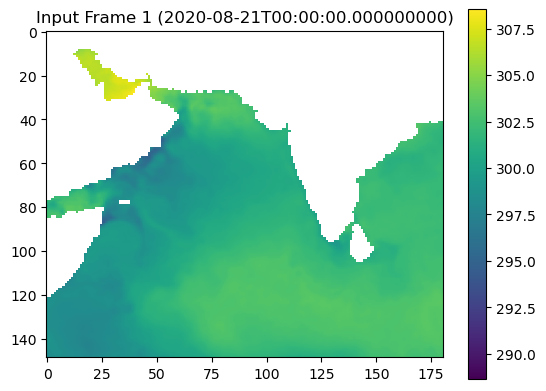

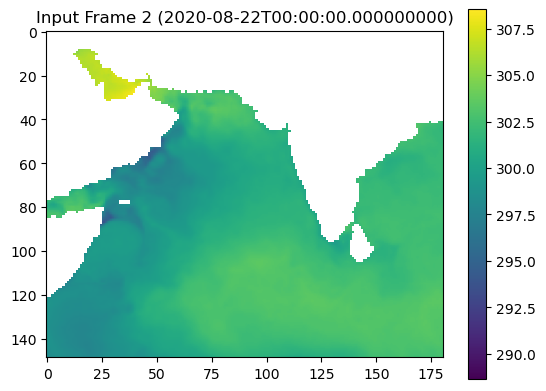

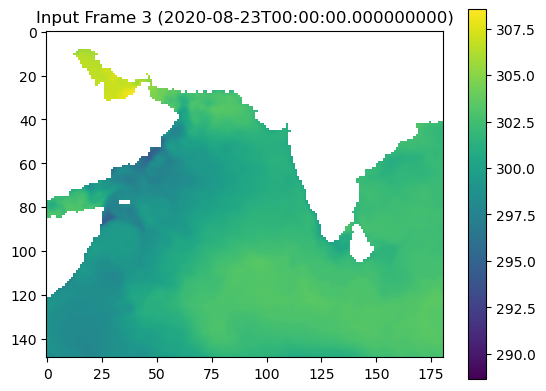

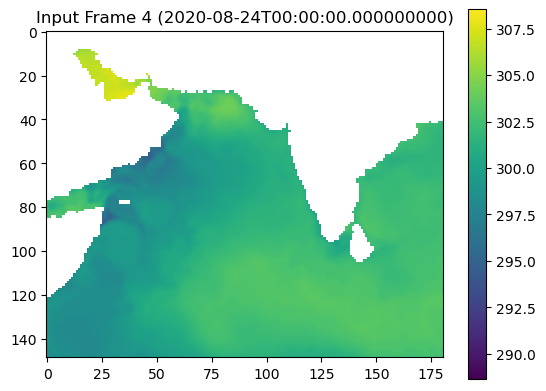

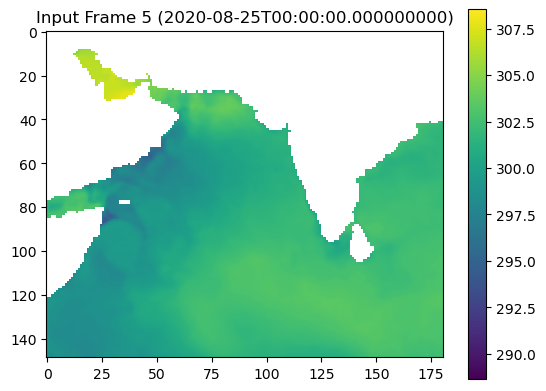

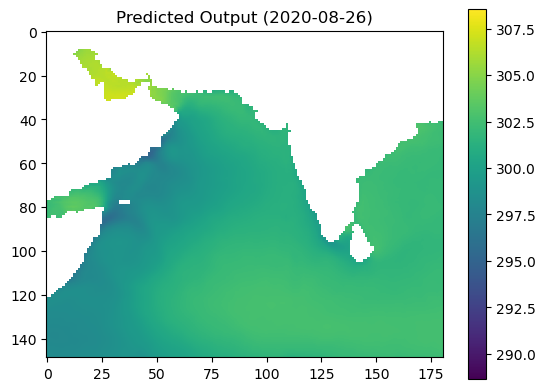

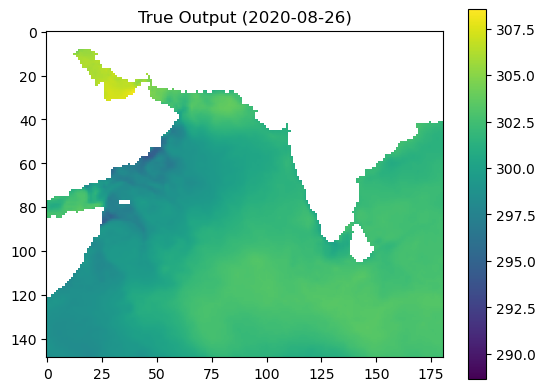

MAE between Predicted Output and True Output: 0.471218466758728
MAE between Last Input Frame and True Output: 0.15075644850730896


In [29]:
date_to_predict = '2020-08-26'
window_size = 5
input_data, predicted_output, true_output = predict_and_plot(date_to_predict, window_size, model, zarr_ds)

predicted_mae = compute_mae(true_output, predicted_output)
print(f"MAE between Predicted Output and True Output: {predicted_mae}")

last_input_frame = input_data[-1]  # Assuming input_data is a sequence and the last frame is the last item in the sequence
last_frame_mae = compute_mae(true_output, last_input_frame)
print(f"MAE between Last Input Frame and True Output: {last_frame_mae}")

In [46]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 149, 181)]        0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 5, 26969)             0         ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 multi_head_attention (Mult  (None, 5, 26969)             7813136   ['time_distributed[0][0]',    
 iHeadAttention)                                          5          'time_distributed[0][0]']    
                                                                                              

In [8]:
X_train_np.shape

(3205, 10, 149, 181)